
Let's study a Medical Insurance Dataset and build a model able to predict the Insurance Charges depending on the attributes of individuals.
 

In [61]:
# import the packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import r2_score

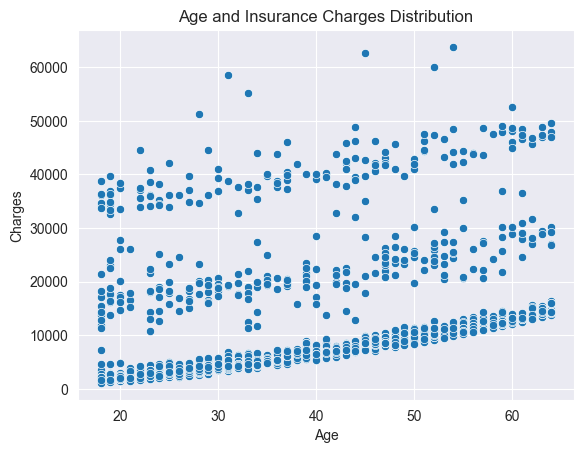

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [62]:
# Plot a scatter plot with age on the x-axis and charges on the y-axis.

df = pd.read_csv('insurance.csv',sep=',')
x = df['age'].values.reshape(-1,1)
y = df['charges'].values
sns.scatterplot(data=df, x='age', y='charges')
ax = plt.gca()
ax.set_title("Age and Insurance Charges Distribution")
ax.set_xlabel("Age")
ax.set_ylabel("Charges")
plt.show()
df

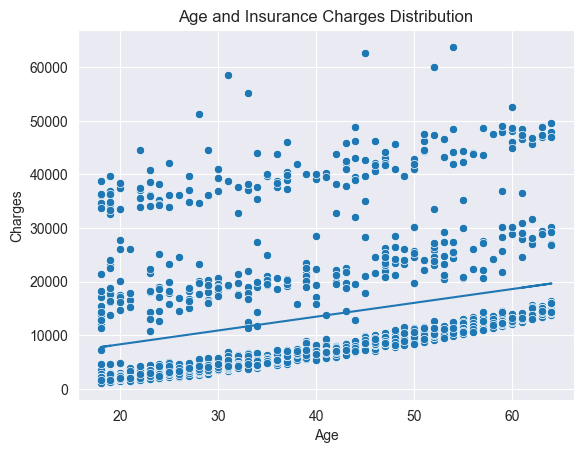

In [63]:
#Using linear_model.LinearRegression() from sklearn, fit a model to your data, and make predictions on data.
#Plot another scatter plot with the best-fit line.
df = pd.read_csv('insurance.csv',sep=',')
x = df['age'].values.reshape(-1,1)
y = df['charges'].values
sns.scatterplot(data=df, x='age', y='charges')
model = linear_model.LinearRegression()
model.fit(x,y)
plt.plot(x, model.predict(x))
ax = plt.gca()
ax.set_title("Age and Insurance Charges Distribution")
ax.set_xlabel("Age")
ax.set_ylabel("Charges")
plt.show()

As we look at the scatter plot and the linear model prediction, we can see a strong inconsistency:
there are three clearly visible clusters or data points, each of the clusters, observed separately, would produce
a linear regression model with a strong fit, but all together the model does not provide us with accurate data.

I suggest studying the data more thoroughly to see the feature that defines the distribution into the clusters.

<Axes: xlabel='age', ylabel='charges'>

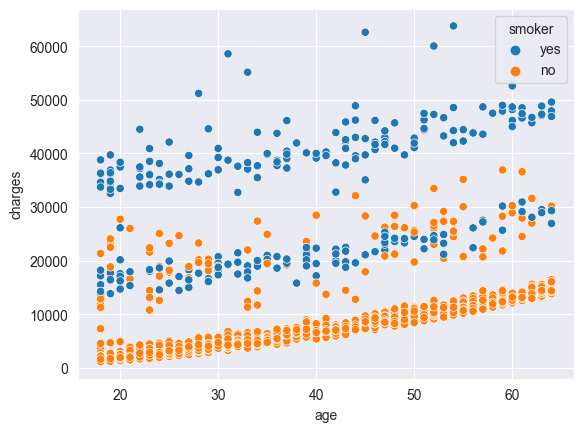

In [64]:
sns.scatterplot(data=df, x='age', y='charges', hue='smoker')
# After couple variables checked through 'hue' argument, we can see the affect of 'smoker' feature

Although it's clear that whether a person is a smoker defines the distribution, there is something else to separate both smokers and non-smokers out of their clusters.

I suggest separately studying what affects the separation for smokers and non-smokers, as long as the third cluster (the one in the middle) might only Coincidentally Overlap for two groups

<Axes: xlabel='age', ylabel='charges'>

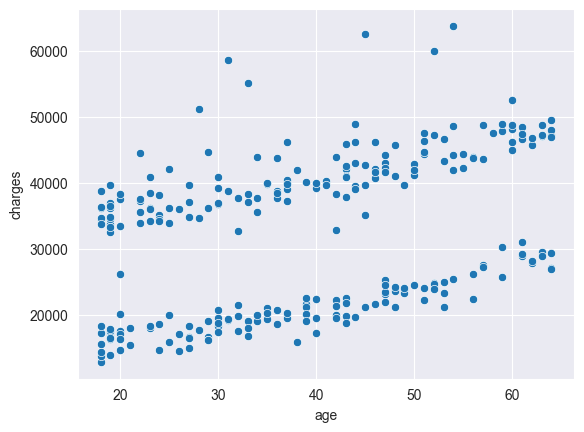

In [65]:
sns.scatterplot(data=df.loc[df['smoker']=='yes'],x='age', y='charges')

So clearly, there is a factor of distribution on the sample of smokers

<Axes: xlabel='age', ylabel='charges'>

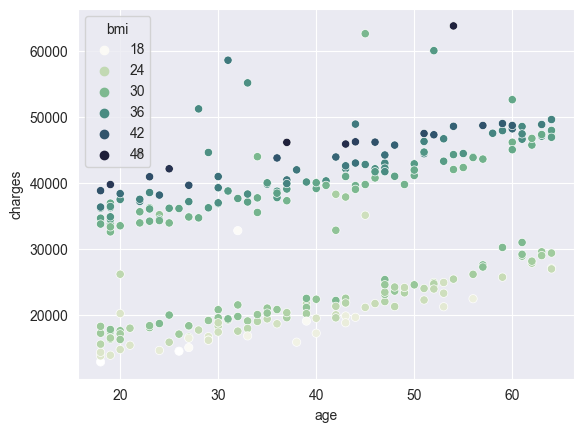

In [66]:
sns.scatterplot(data=df.loc[df['smoker']=='yes'],x='age', y='charges', hue='bmi', palette='ch:start=.2,rot=-.6,light=1,dark=0')

We can see a correlation between the diversion into groups and person's bmi

Filtering the sample by people with bmi<30 we still get one cluster:

<Axes: xlabel='age', ylabel='charges'>

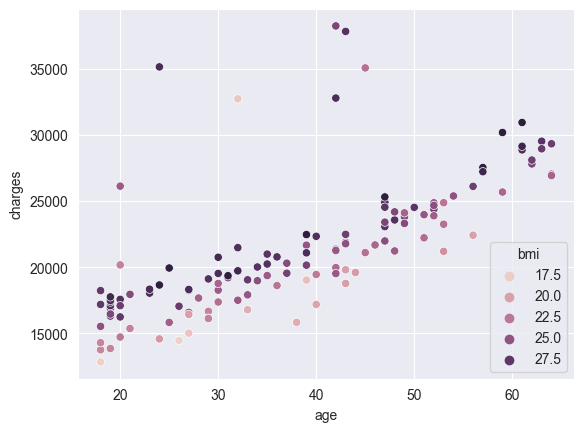

In [67]:
sns.scatterplot(data=df.loc[(df['smoker']=='yes') & (df['bmi']<30)],x='age', y='charges', hue='bmi')

Whereas when widening the sample to bmi<35 we see two clusters:

<Axes: xlabel='age', ylabel='charges'>

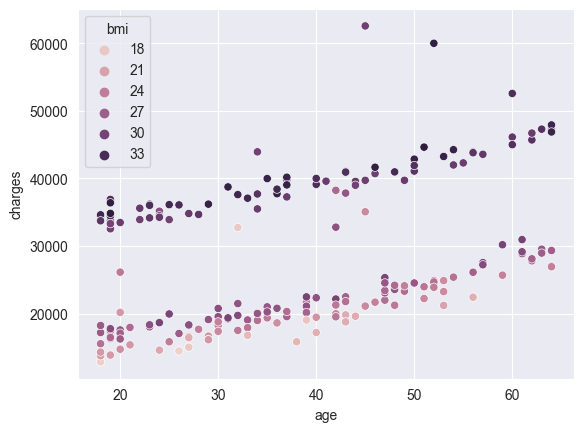

In [68]:
sns.scatterplot(data=df.loc[(df['smoker']=='yes') & (df['bmi']<35)],x='age', y='charges', hue='bmi')

So, we conclude the middle cluster is formed from smokers with bmi<30 and non-smokers with yet unknown condition

Let's study the second group now.

<Axes: xlabel='age', ylabel='charges'>

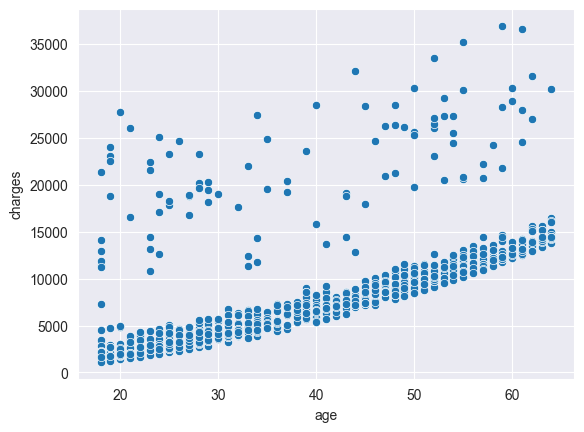

In [69]:
sns.scatterplot(data=df.loc[df['smoker']=='no'],x='age', y='charges')

Let's see if the bmi filter applies to this sample

<Axes: xlabel='age', ylabel='charges'>

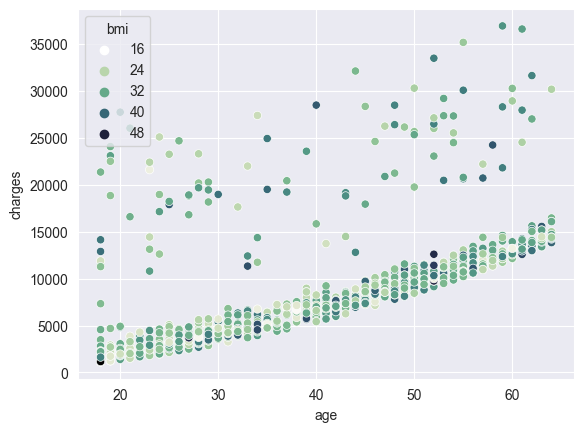

In [70]:
sns.scatterplot(data=df.loc[df['smoker']=='no'],x='age', y='charges', hue='bmi', palette='ch:start=.2,rot=-.6,light=1,dark=0')

We can see our hypothesis about the middle group being formed by different features of smokers and non-smokers has been proven, there is no visible tendency for bmi as a factor of distribution of non-smokers

In fact, from what we can see, there is no base for the distribution among non-smoking population out of the attributes from the dataset. Example:

<Axes: xlabel='age', ylabel='charges'>

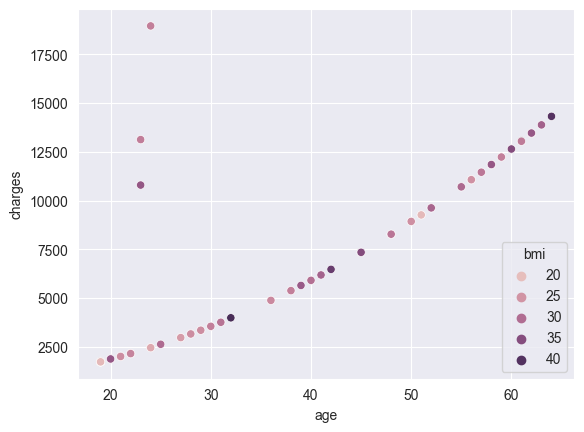

In [71]:
sns.scatterplot(data=df.loc[(df['smoker']=='no')&(df['sex']=='female')&(df['region']=='southwest')&(df['children']==0)],x='age', y='charges', hue='bmi')

In this vivid case we see the very specific sample of population: non-smoking women from southwest with no children. Each of the attributes known to us has been considered, and the only left bmi is expressed by the 'hue' parameter.

As we can see, out of known features, none describe the outlying tendency of three observations from above. The same phenomenon can be seen with all the other groups of people with same features.

The hypothesis is that the dataset does not provide us with all the determinants of the Insurance Charges. To prove or disprove the hypothesis, let's build a multiple regression model.

In [72]:
def multiple_regression(cluster):
    pd.set_option('mode.chained_assignment', None)
    regions = cluster['region'].unique()
    df_new = pd.DataFrame(cluster.loc[:, (cluster.columns != 'sex') & (cluster.columns != 'region') & (cluster.columns != 'smoker')])
    for i in regions:
        de = cluster.loc[cluster['region'] == i]
        de.loc[:, i] = 1
        de1 = cluster.loc[cluster['region'] != i]
        de1.loc[:, i] = 0
        df_new[i] = de.combine_first(de1)[i]
    de = cluster.loc[cluster['sex'] == 'male']
    de.loc[:, 'sex'] = 1
    de1 = cluster.loc[cluster['region'] != 'male']
    de1.loc[:, 'sex'] = 0
    df_new['sex'] = de.combine_first(de1)['sex']
    de = cluster.loc[cluster['smoker'] == 'yes']
    de.loc[:, 'smoker'] = 1
    de1 = cluster.loc[cluster['smoker'] != 'yes']
    de1.loc[:, 'smoker'] = 0
    df_new['smoker'] = de.combine_first(de1)['smoker']
    x = df_new.loc[:, df_new.columns != 'charges']
    y = df_new.loc[:, 'charges']
    multiple_regr = linear_model.LinearRegression()
    multiple_regr.fit(x, y)
    pd.reset_option("mode.chained_assignment")
    return df_new, multiple_regr


cluster = df.loc[df['smoker']=='no']
cluster_adapted,model = multiple_regression(cluster)
cluster_adapted

,age,bmi,children,charges,southeast,northwest,northeast,southwest,sex,smoker
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,0,0,1,0
4,32,28.880,0,3866.85520,0,1,0,0,1,0
5,31,25.740,0,3756.62160,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1332,52,44.700,3,11411.68500,0,0,0,1,0,0
1333,50,30.970,3,10600.54830,0,1,0,0,1,0
1334,18,31.920,0,2205.98080,0,0,1,0,0,0
1335,18,36.850,0,1629.83350,1,0,0,0,0,0


We form a new dataframe, to be used for multiple linear regression purposes, where categorical values presented as 0 and 1.

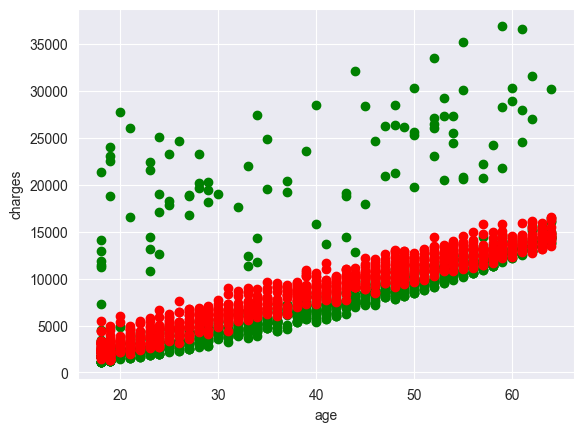

In [73]:
x=cluster_adapted.loc[:,cluster_adapted.columns!='charges']
y=cluster_adapted.loc[:,'charges']
plt.scatter(x=cluster_adapted['age'],y=y,color='g')
plt.scatter(x=cluster_adapted['age'],y=model.predict(x),color='r')
ax=plt.gca()
ax.set_xlabel('age')
ax.set_ylabel('charges')
plt.show()

Now we have trained the Multiple Linear Regression model with our dataset. Red observations on the scatter plot represent the model's prediction, whereas the green ones represent actual observation.

We have proven the hypothesis that the dataset's attributes do not cover all the determinants of the insurance charges and there is at least one more attribute to cause the diversion among non-smoking population.

I suggest disregarding the observations that show more than 35% deviation from the charges predicted by the model

P.S.: Percentage was determined manually. Necessary to mention, the deviation has shown to be high among predictable observations, only due to the deviation of the model itself, because of the later disregarded observations.

Text(0, 0.5, 'charges')

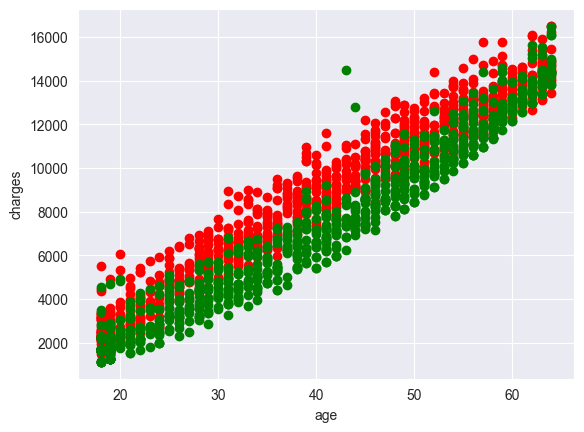

In [74]:
def disregard(cluster, model, coef):
    cluster_disregarded = pd.DataFrame()
    for i in cluster.index:
        i = cluster.loc[i].to_frame().transpose()
        x = model.predict(i.loc[:, i.columns != 'charges']).item(0)
        if (abs(x - float(i['charges'].to_numpy().item(0))) / x) <= coef:
            cluster_disregarded = pd.concat([cluster_disregarded, i], ignore_index=True)
    return cluster_disregarded

cluster_disregarded= disregard(cluster_adapted, model, coef=0.35)
plt.scatter(x=cluster_disregarded['age'], y=model.predict(cluster_disregarded.loc[:,cluster_disregarded.columns!='charges']), color='r')
plt.scatter(x=cluster_disregarded['age'], y=cluster_disregarded['charges'],color='g')
ax=plt.gca()
ax.set_xlabel('age')
ax.set_ylabel('charges')

Green marks stand for separated observations, red are current model's prediction.

Now we successfully separated observations of non-smokers not affected by unknown determinants, these are now valid to be used for prediction model building, based on the only determinants we operate.

Let's now segregate the outliers for all of the clusters.

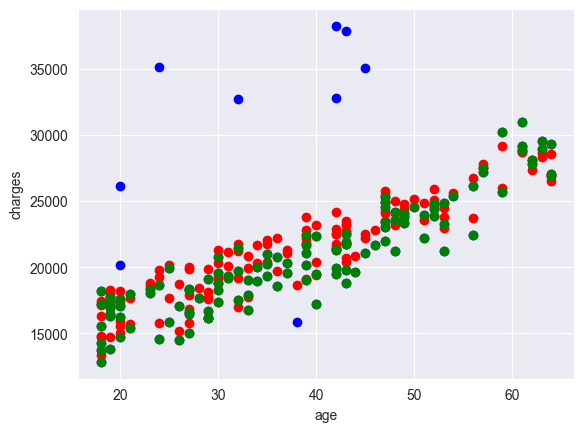

In [75]:
cluster=df.loc[(df['smoker']=='yes')&(df['bmi']<30)]
cluster_adapted, model =multiple_regression(cluster)
cluster_disregarded= disregard(cluster_adapted, model, coef=0.15)
plt.scatter(x=cluster['age'],y=cluster['charges'],color='b')
plt.scatter(x=cluster_adapted['age'],y=model.predict(cluster_adapted.loc[:, cluster_adapted.columns != 'charges']),color='r')
plt.scatter(x=cluster_disregarded['age'],y=cluster_disregarded['charges'],color='g')
ax=plt.gca()
ax.set_xlabel('age')
ax.set_ylabel('charges')
plt.show()

In this case of smokers with bmi<30, we disregard the blue occurrences

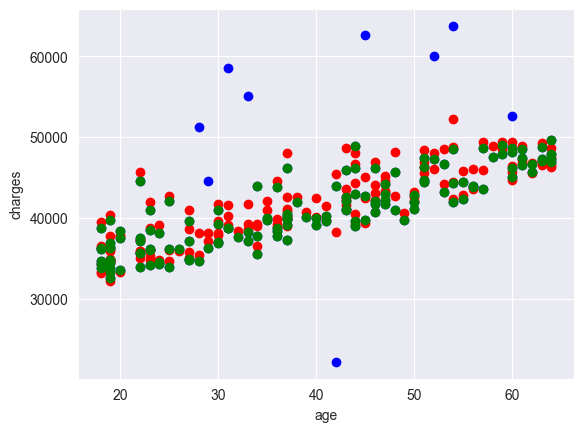

In [76]:
cluster=df.loc[(df['smoker']=='yes')&(df['bmi']>=30)]
cluster_adapted, model =multiple_regression(cluster)
cluster_disregarded= disregard(cluster_adapted, model, coef=0.15)
plt.scatter(x=cluster['age'],y=cluster['charges'],color='b')
plt.scatter(x=cluster_adapted['age'],y=model.predict(cluster_adapted.loc[:, cluster_adapted.columns != 'charges']),color='r')
plt.scatter(x=cluster_disregarded['age'],y=cluster_disregarded['charges'],color='g')
ax=plt.gca()
ax.set_xlabel('age')
ax.set_ylabel('charges')
plt.show()

We now did the same for smokers with bmi>=30

Let's merge the whole dataset of three clusters with outliers dropped

11.96 % disregarded


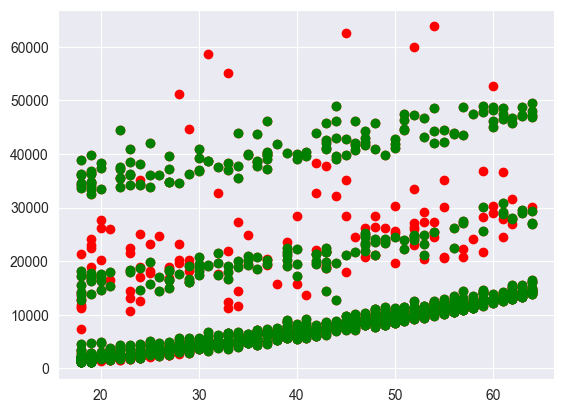

In [77]:
df_disregarded = pd.DataFrame()
for cluster,coef in [(df.loc[(df['smoker']=='yes')&(df['bmi']>=30)],0.15),(df.loc[(df['smoker']=='yes')&(df['bmi']<30)],0.15),(df.loc[(df['smoker']=='no')],0.35)]:
    cluster_adapted, model = multiple_regression(cluster)
    cluster_disregarded = disregard(cluster_adapted, model, coef=coef)
    df_disregarded = pd.concat([df_disregarded, cluster_disregarded], ignore_index=True)
plt.scatter(x=df['age'], y=df['charges'],color='r')
plt.scatter(x=df_disregarded['age'], y=df_disregarded['charges'],color='g')
df_disregarded
print(round(100*(df.shape[0]-df_disregarded.shape[0])/df.shape[0],2),'% disregarded')

The red occurrences on the scatter plot are disregarded, whereas green are valid to be explained through the by determinants. Although it might seem like a lot not to take into account, we have only disregarded 11.96% of the sample.

Let's now rebuild the multiple regression model to no take into account misleading occurrences

I suggest first simulating the model for the whole dataset, as long as it might seem like linear distribution into clusters.

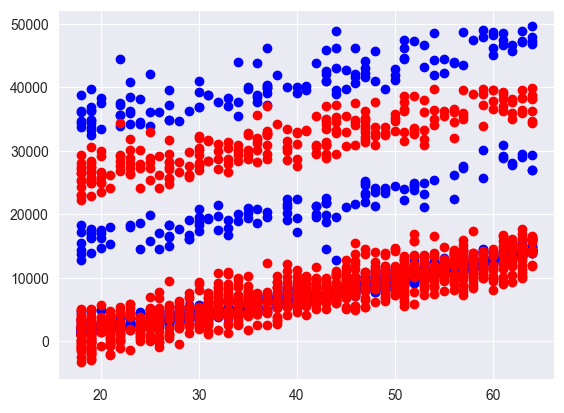

In [78]:
x = df_disregarded.loc[:, df_disregarded.columns != 'charges']
y = df_disregarded.loc[:, 'charges']
multiple_regr = linear_model.LinearRegression()
multiple_regr.fit(x, y)
plt.scatter(x=df_disregarded['age'],y=df_disregarded['charges'],color='b')
plt.scatter(x=df_disregarded['age'],y=multiple_regr.predict(df_disregarded.loc[:, df_disregarded.columns != 'charges']),color='r')

Blue represents actual occurrences, red is the model's prediction

As we can see, it is necessary for us two build three separate regression models. This phenomenon occurs because determinant of 'bmi' only applies linearly when considering a single cluster, at the same time thee cluster of non-smokers is significantly widened, due to the exaggeration of bmi's influence. This might happen if Insurance Company Policy has a specific mark of bmi>=30 to increase the charge non-linearly.

So, the right thing to do is to get back to three separate regression models.

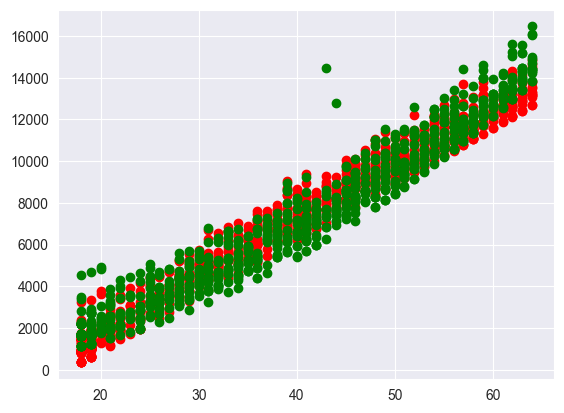

In [79]:
def model1(data_train, data_predict):
    model1 = linear_model.LinearRegression()
    x1_train = data_train.loc[data_train['smoker']==0, data_train.columns!='charges']
    x1_predict = data_predict.loc[data_predict['smoker']==0, data_predict.columns!='charges']
    y1_train = data_train.loc[data_train['smoker']==0, data_train.columns=='charges']
    y1_actual = data_predict.loc[data_predict['smoker']==0, data_predict.columns=='charges']
    model1.fit(x1_train,y1_train)
    y1_predict = model1.predict(x1_predict)
    plt.scatter(x=x1_predict['age'],y=y1_predict, color='r')
    plt.scatter(x=x1_predict['age'],y=y1_actual,color='g')
    return y1_actual, y1_predict
model1(df_disregarded, df_disregarded);

As we can see, the model has seemingly improved after disregarding misleading fields.

0.9809931278796543

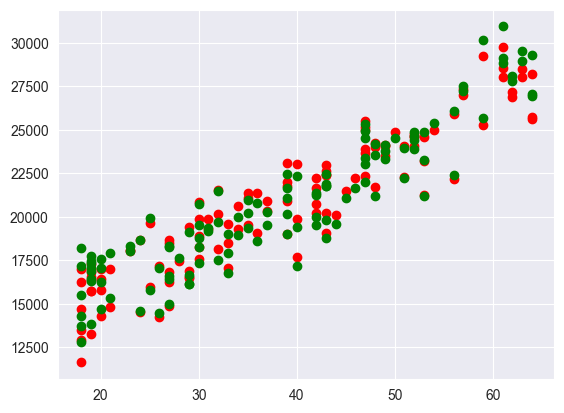

In [80]:
def model2(data_train, data_predict):
    model2 = linear_model.LinearRegression()
    x2_train = data_train.loc[(data_train['smoker']==1)&(data_train['bmi']<30), data_train.columns!='charges']
    x2_predict = data_predict.loc[(data_predict['smoker']==1)&(data_predict['bmi']<30), data_predict.columns!='charges']
    y2_train = data_train.loc[(data_train['smoker']==1)&(data_train['bmi']<30), data_train.columns=='charges']
    y2_actual = data_predict.loc[(data_predict['smoker']==1)&(data_predict['bmi']<30), data_predict.columns=='charges']
    model2.fit(x2_train,y2_train)
    y2_predict = model2.predict(x2_predict)
    plt.scatter(x=x2_predict['age'],y=y2_predict, color='r')
    plt.scatter(x=x2_predict['age'],y=y2_actual,color='g')
    return y2_actual, y2_predict
y2, y2_predict = model2(df_disregarded, df_disregarded);
r2_score(y2, y2_predict)

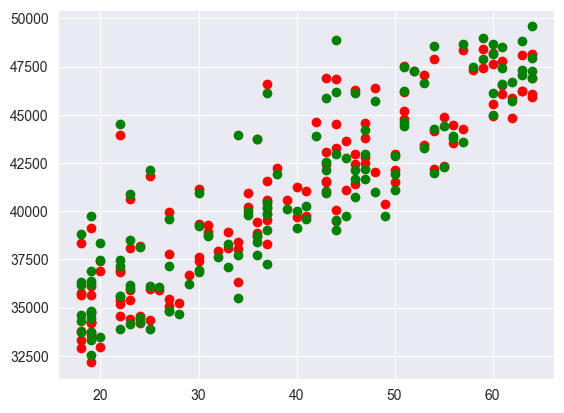

In [81]:
def model3(data_train, data_predict):
    model3 = linear_model.LinearRegression()
    x3_train = data_train.loc[(data_train['smoker']==1)&(data_train['bmi']>=30), data_train.columns!='charges']
    x3_predict = data_predict.loc[(data_predict['smoker']==1)&(data_predict['bmi']>=30), data_predict.columns!='charges']
    y3_train = data_train.loc[(data_train['smoker']==1)&(data_train['bmi']>=30), data_train.columns=='charges']
    y3_actual = data_predict.loc[(data_predict['smoker']==1)&(data_predict['bmi']>=30), data_predict.columns=='charges']
    model3.fit(x3_train,y3_train)
    y3_predict = model3.predict(x3_predict)
    plt.scatter(x=x3_predict['age'],y=y3_predict, color='r')
    plt.scatter(x=x3_predict['age'],y=y3_actual,color='g')
    return y3_actual, y3_predict
model3(df_disregarded, df_disregarded);

Now we have finished building the models for predictions, as can bee seen, they show a strong fit.

I suggest assessing the models.

Model1 R^2 0.41732934107851793
Model2 R^2 0.5504981760247831
Model3 R^2 0.6023684036926924
Total R^2 0.4502213020554413


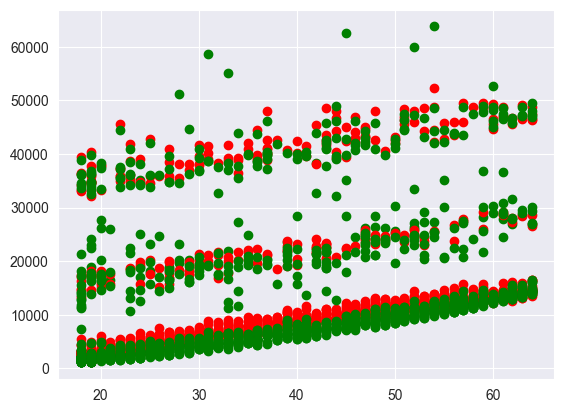

In [82]:
df_adapted, inaccurate_model = multiple_regression(df)
y1, y1_pred = model1(df_adapted, df_adapted)
print('Model1 R^2',r2_score(y1,y1_pred))
y2, y2_pred = model2(df_adapted, df_adapted)
print('Model2 R^2',r2_score(y2,y2_pred))
y3, y3_pred = model3(df_adapted, df_adapted)
print('Model3 R^2',r2_score(y3,y3_pred))
print('Total R^2',(r2_score(y1,y1_pred)*y1.shape[0]+r2_score(y2,y2_pred)*y2.shape[0]+r2_score(y3,y3_pred)*y3.shape[0])/(y1.shape[0]+y2.shape[0]+y3.shape[0]))

Above we can see the prediction on uncleaned dataset of the model trained by the same uncleaned dataset.

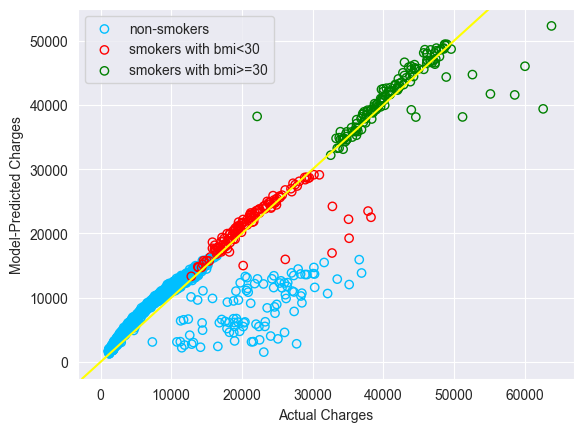

In [83]:
plt.scatter(x=y1, y=y1_pred, color="deepskyblue", marker="o", facecolors="none")
plt.scatter(x=y2, y=y2_pred, color="red", marker="o", facecolors="none")
plt.scatter(x=y3, y=y3_pred, color="green", marker="o", facecolors="none")
ax = plt.gca()
ax.axline((0, 0), slope=1,color='yellow')
ax.set_xlabel('Actual Charges')
ax.set_ylabel('Model-Predicted Charges')
ax.legend(['non-smokers','smokers with bmi<30','smokers with bmi>=30'])

Above is the accuracy of the prediction on the original dataset by the model trained with the original non-filtered dataset as well.

Let's see the prediction on the uncleaned dataset of model trained by the cleaned dataset.

Model1 R^2 0.36161892446379096
Model2 R^2 0.513287892553299
Model3 R^2 0.5833852034836069
Total R^2 0.4002746848086488


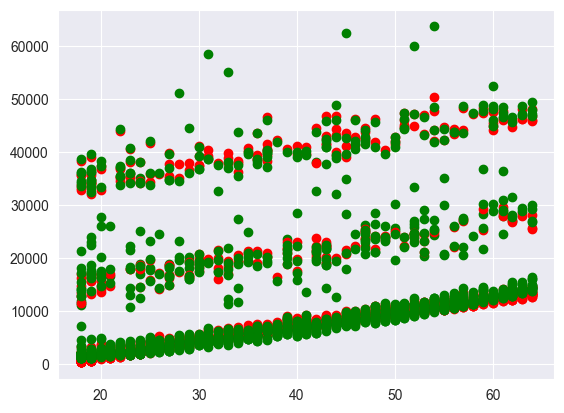

In [84]:
cols=df_disregarded.columns.tolist()
cols[6], cols[7] = cols[7], cols[6]
cols[4], cols[5] = cols[5], cols[4]
df_disregarded = df_disregarded[cols]
y1, y1_pred = model1(df_disregarded, df_adapted)
print('Model1 R^2',r2_score(y1,y1_pred))
y2, y2_pred = model2(df_disregarded, df_adapted)
print('Model2 R^2',r2_score(y2,y2_pred))
y3, y3_pred = model3(df_disregarded, df_adapted)
print('Model3 R^2',r2_score(y3,y3_pred))
print('Total R^2',(r2_score(y1,y1_pred)*y1.shape[0]+r2_score(y2,y2_pred)*y2.shape[0]+r2_score(y3,y3_pred)*y3.shape[0])/(y1.shape[0]+y2.shape[0]+y3.shape[0]))

And the accuracy of the prediction above:

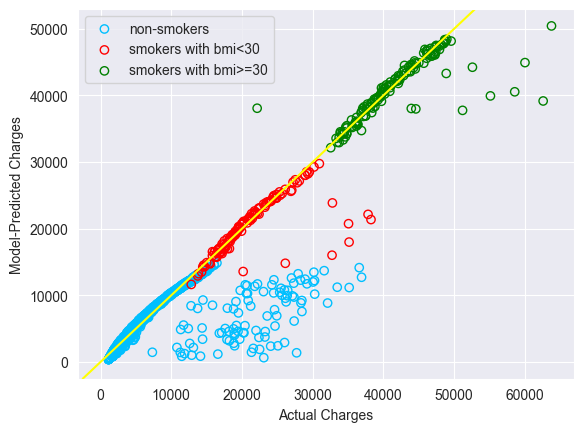

In [85]:
plt.scatter(x=y1, y=y1_pred, color="deepskyblue", marker="o", facecolors="none")
plt.scatter(x=y2, y=y2_pred, color="red", marker="o", facecolors="none")
plt.scatter(x=y3, y=y3_pred, color="green", marker="o", facecolors="none")
ax = plt.gca()
ax.axline((0, 0), slope=1,color='yellow')
ax.set_xlabel('Actual Charges')
ax.set_ylabel('Model-Predicted Charges')
ax.legend(['non-smokers','smokers with bmi<30','smokers with bmi>=30'])

And Finally,
Let's see the prediction on thee cleaned dataset by the model trained with the same cleaned data:

Model1 R^2 0.9759271895834156
Model2 R^2 0.9809931278796543
Model3 R^2 0.9562123577439351
Total R^2 0.9741671687560636


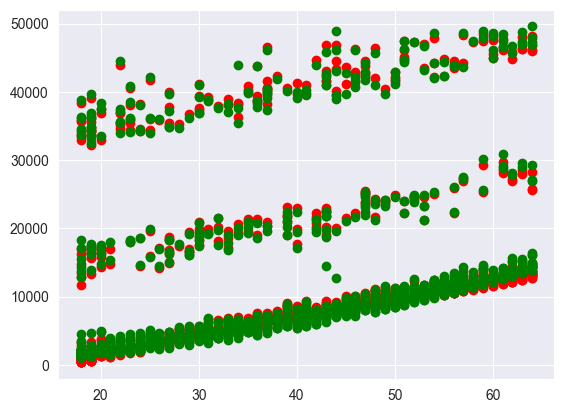

In [86]:
y1, y1_pred = model1(df_disregarded, df_disregarded)
print('Model1 R^2',r2_score(y1,y1_pred))
y2, y2_pred = model2(df_disregarded, df_disregarded)
print('Model2 R^2',r2_score(y2,y2_pred))
y3, y3_pred = model3(df_disregarded, df_disregarded)
print('Model3 R^2',r2_score(y3,y3_pred))
print('Total R^2',(r2_score(y1,y1_pred)*y1.shape[0]+r2_score(y2,y2_pred)*y2.shape[0]+r2_score(y3,y3_pred)*y3.shape[0])/(y1.shape[0]+y2.shape[0]+y3.shape[0]))

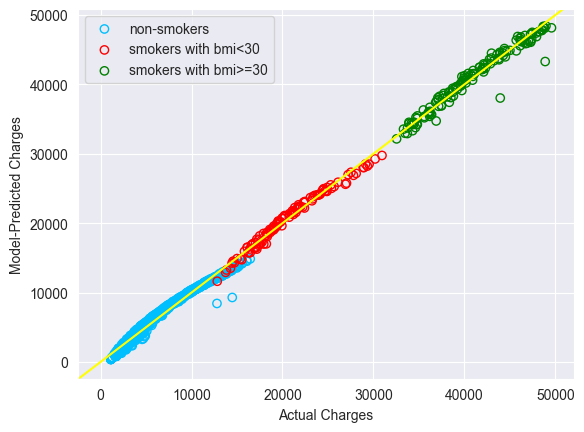

In [87]:
plt.scatter(x=y1, y=y1_pred, color="deepskyblue", marker="o", facecolors="none")
plt.scatter(x=y2, y=y2_pred, color="red", marker="o", facecolors="none")
plt.scatter(x=y3, y=y3_pred, color="green", marker="o", facecolors="none")
ax = plt.gca()
ax.axline((0, 0), slope=1,color='yellow')
ax.set_xlabel('Actual Charges')
ax.set_ylabel('Model-Predicted Charges')
ax.legend(['non-smokers','smokers with bmi<30','smokers with bmi>=30'])

Above we can see the accuracy of model prediction for the model trained by the cleaned dataset and the prediction made for the same cleaned dataset

CONCLUSIONS

We have determined non-linear affect of such features as 'smoker' and 'bmi'(at specific point of 30) and decided to create three separate models for three clustes, to be able to increase the margin of error of prediction

The dataset we analysed has indeed not covered all the determinats of Insurance Charges for some cases. We have determined the 11.96% of the dataset fields, highly misleading the prediction model. As long as we suppose there is another determinant not known to us, that highly increases the insurance charges for 11.96% of the sample, and have decided to disregard those occurrences.

This lead us to the model able to predict the Insurance charges for cases, that do not possess the unknown determinant with the accuracy of 97.4% (R^2 total = 0.974).

P.S: The unknown determinant that so much affects 11.96% of the sample population, in case of Medical Insurance Dataset, could most likely be presence of specific continuous conditions.
